In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare data

In [2]:
data = pd.read_csv('../../../data/processed.cleveland.data.csv')

## Drop categorical features
## Drop NULL values
data = data.dropna()


## calculate mean of age column
mean = data.loc[:,"age"].mean()
data['age'] = np.where(data['age'] >= mean, 0, 1)

## Make goal column binary
data['Probability'] = np.where(data['Probability'] > 0, 1, 0)

protected_attribute = 'age'

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dataset_orig = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

(dataset_orig.head(5))

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Probability
0,1.0,1.0,0.000000,0.481132,0.244292,1.0,1.0,0.603053,0.0,0.370968,1.0,0.000000,0.75,0.0
1,1.0,1.0,1.000000,0.622642,0.365297,0.0,1.0,0.282443,1.0,0.241935,0.5,1.000000,0.00,1.0
2,1.0,1.0,1.000000,0.245283,0.235160,0.0,1.0,0.442748,1.0,0.419355,0.5,0.666667,1.00,1.0
3,0.0,1.0,0.666667,0.339623,0.283105,0.0,0.0,0.885496,0.0,0.564516,1.0,0.000000,0.00,0.0
4,0.0,0.0,0.333333,0.339623,0.178082,0.0,1.0,0.770992,0.0,0.225806,0.0,0.000000,0.00,0.0


In [3]:
# This dataset size is very small. So repeating it to make it bigger

dataset_orig = pd.concat([dataset_orig]*5, ignore_index=True)

# Transform data using LFR¶

In [4]:
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.datasets import BinaryLabelDataset
from IPython.display import Markdown, display
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

protected_attribute = "age"
dataset_orig_train, dataset_orig_test = train_test_split(dataset_orig, test_size=0.2, shuffle = True)
privileged_groups = [{protected_attribute: 1}]
unprivileged_groups = [{protected_attribute: 0}]

TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
#          k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1)

dataset_orig_train = BinaryLabelDataset(df=dataset_orig_train, label_names=['Probability'], protected_attribute_names=[protected_attribute])

TR.fit(dataset_orig_train, maxiter=5000, maxfun=5000)

dataset_transf = TR.transform(dataset_orig_train)
dataset_orig_train, yy = dataset_transf.convert_to_dataframe()

from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

step: 0, loss: 1.8848310614857846, L_x: 0.3303633282349973,  L_y: 0.6996243366365,  L_z: 0.02363806183133869
step: 250, loss: 0.8585601670875052, L_x: 0.33421740294804203,  L_y: 0.7073056084849679,  L_z: 0.0029582476914611355
step: 500, loss: 0.8583246733357598, L_x: 0.3342124962815037,  L_y: 0.7072881486826257,  L_z: 0.002953887993806381
step: 750, loss: 0.7843663277365097, L_x: 0.33479003386308576,  L_y: 0.7068862974898467,  L_z: 0.001482642598160644
step: 1000, loss: 0.7792478952858661, L_x: 0.3344658920388142,  L_y: 0.7074160859401215,  L_z: 0.0013697430085071293
step: 1250, loss: 0.7178083317925572, L_x: 0.33462749647160367,  L_y: 0.7069854019414311,  L_z: 0.00014953309772819945
step: 1500, loss: 0.7117795684109124, L_x: 0.3346362159735077,  L_y: 0.7070171638285911,  L_z: 2.832084845172389e-05
step: 1750, loss: 0.7119227933499257, L_x: 0.3346348139886237,  L_y: 0.7070168591676905,  L_z: 3.119172084697919e-05
step: 2000, loss: 0.711056893018624, L_x: 0.3346316831343339,  L_y: 0.707

# Graph

In [179]:
causal_graph = """
digraph {
age;
fbs;
exang;
oldpeak;
Probability;
U[label="Unobserved Confounders"];
age -> exang; exang -> Probability;
age -> oldpeak; oldpeak -> Probability
oldpeak -> exang;
fbs -> Probability;
age -> Probability;
U->age;U->Probability;
}
"""

## dowhy works for binary inputs only
# dataset_orig_train = pd.concat([dataset_orig_train]*5, ignore_index=True)
dataset_orig_train['Probability'] = np.where(dataset_orig_train['Probability'] == 0, False, True)
dataset_orig_train[protected_attribute] = np.where(dataset_orig_train[protected_attribute] == 1, True, False)

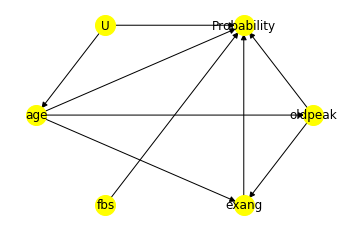

In [180]:
# With graph
model=CausalModel(
        data = dataset_orig_train,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [181]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
──────(Expectation(Probability|fbs))
d[age]                              
Estimand assumption 1, Unconfoundedness: If U→{age} and U→Probability then P(Probability|age,fbs,U) = P(Probability|age,fbs)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [182]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
──────(Expectation(Probability|fbs))
d[age]                              
Estimand assumption 1, Unconfoundedness: If U→{age} and U→Probability then P(Probability|age,fbs,U) = P(Probability|age,fbs)

## Realized estimand
b: Probability~age+fbs
Target units: ate

## Estimate
Mean value: -0.18970385674931128

Causal Estimate is -0.18970385674931128


In [15]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                              
──────(Expectation(Probability|thalach,thal,sex))
d[age]                                           
Estimand assumption 1, Unconfoundedness: If U→{age} and U→Probability then P(Probability|age,thalach,thal,sex,U) = P(Probability|age,thalach,thal,sex)

## Realized estimand
b: Probability~age+thalach+thal+sex
Target units: atc

## Estimate
Mean value: 0.0

Causal Estimate is 0.0


# Add Random Common Cause

In [63]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.0
New effect:0.004444318249422658



# Replace Treatment with Placebo

In [17]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.0
New effect:-0.0003812604747241289
p value:0.58



# Remove Random Subset of Data

In [18]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.0
New effect:0.020521016664865162
p value:0.53

